In [18]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset

In [19]:
# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate 100k random binary sequences
num_samples = 100000
data = []

for _ in range(num_samples):
    length = random.randint(1, 16)  # Random length between 1 and 16
    sequence = np.random.choice([0, 1], size=length).tolist()  # Random binary sequence
    count_of_ones = sum(sequence)  # Count the number of '1's
    data.append((sequence, count_of_ones))  # Append tuple (sequence, count)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data, columns=['sequence', 'count_of_ones'])

# Split the dataset
train_df = df.sample(frac=0.8, random_state=42)
remaining_df = df.drop(train_df.index)
validation_df = remaining_df.sample(frac=0.5, random_state=42)
test_df = remaining_df.drop(validation_df.index)


In [20]:
# Create Dataset class
class BinarySequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.float32)
        return sequence, label

In [21]:
# Define the RNN model
class RNNBinaryCounter(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, output_size=1):
        super(RNNBinaryCounter, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through RNN
        out, _ = self.rnn(x.unsqueeze(-1), h0)
        
        # Use the last output from the RNN for the final count prediction
        out = self.fc(out[:, -1, :])
        return out


In [22]:
# class RNNBinaryCounter(nn.Module):
#     def __init__(self, input_size=1, hidden_size=16, output_size=1):
#         super(RNNBinaryCounter, self).__init__()
        
#         self.hidden_size = hidden_size
#         self.dropout_prob = 0.1
        
#         # Define the RNN layer
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
#         # Define additional hidden layers and batch normalization
#         self.fc1 = nn.Linear(hidden_size, hidden_size)
#         self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch normalization
#         self.dropout = nn.Dropout(self.dropout_prob)  # Dropout layer
#         self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
#         self.bn2 = nn.BatchNorm1d(hidden_size)  # Batch normalization
        
#         # Define the final output layer
#         self.fc_out = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
#         # Forward propagate through RNN
#         out, _ = self.rnn(x.unsqueeze(-1), h0)
        
#         # Get the output from the last time step
#         out = out[:, -1, :]
        
#         # Pass through the first hidden layer and apply batch normalization
#         out = self.fc1(out)
#         out = self.bn1(out)
#         out = torch.relu(out)
        
#         # Apply dropout after the first hidden layer
#         out = self.dropout(out)
        
#         # Pass through the second hidden layer and apply batch normalization
#         out = self.fc2(out)
#         out = self.bn2(out)
#         out = torch.relu(out)
        
#         # Final output layer
#         out = self.fc_out(out)
#         return out


In [23]:
def pad_sequence(sequence, max_length=16):
    return sequence + [0] * (max_length - len(sequence))

In [24]:
train_df['padded_sequence'] = train_df['sequence'].apply(lambda x: pad_sequence(x))
validation_df['padded_sequence'] = validation_df['sequence'].apply(lambda x: pad_sequence(x))
test_df['padded_sequence'] = test_df['sequence'].apply(lambda x: pad_sequence(x))

# Initialize Datasets and DataLoaders
train_dataset = BinarySequenceDataset(train_df['padded_sequence'], train_df['count_of_ones'])
val_dataset = BinarySequenceDataset(validation_df['padded_sequence'], validation_df['count_of_ones'])
test_dataset = BinarySequenceDataset(test_df['padded_sequence'], test_df['count_of_ones'])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Display dataset sizes and some examples
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
print(f"Test set size: {len(test_df)}\n")

print("Training examples:\n", train_df.head())
print("Validation examples:\n", validation_df.head())
print("Test examples:\n", test_df.head())

Training set size: 80000
Validation set size: 10000
Test set size: 10000

Training examples:
                                          sequence  count_of_ones  \
75721     [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]              7   
80184  [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]              5   
19864                                [1, 0, 0, 1]              2   
76699           [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]              5   
92991     [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]              5   

                                        padded_sequence  
75721  [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]  
80184  [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]  
19864  [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
76699  [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]  
92991  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]  
Validation examples:
                                       sequence  count_of_ones  \
52882                    [0, 0, 0, 1, 1, 0, 1]              3 

In [25]:
# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNBinaryCounter().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Initialize lists to store MAE values for each epoch
train_mae_history = []
val_mae_history = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_mae = 0
    
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), labels)  # MSE loss for training
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate MAE manually for training
        mae = torch.abs(outputs.squeeze() - labels).mean().item()
        train_mae += mae
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    train_mae_history.append(train_mae)

    # Validation - Calculate MAE while keeping MSE as the loss function
    model.eval()
    val_loss = 0
    val_mae = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            
            # Calculate MSE Loss
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            
            # Calculate MAE manually for validation
            mae = torch.abs(outputs.squeeze() - labels).mean().item()
            val_mae += mae
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    val_mae_history.append(val_mae)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss (MSE): {train_loss:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")



Epoch [1/10], Train Loss (MSE): 6.3560, Train MAE: 1.8359, Val MAE: 0.3690
Epoch [2/10], Train Loss (MSE): 0.1381, Train MAE: 0.1964, Val MAE: 0.1088
Epoch [3/10], Train Loss (MSE): 0.0231, Train MAE: 0.0801, Val MAE: 0.0531
Epoch [4/10], Train Loss (MSE): 0.0082, Train MAE: 0.0495, Val MAE: 0.0378
Epoch [5/10], Train Loss (MSE): 0.0048, Train MAE: 0.0421, Val MAE: 0.0490
Epoch [6/10], Train Loss (MSE): 0.0032, Train MAE: 0.0359, Val MAE: 0.0267
Epoch [7/10], Train Loss (MSE): 0.0023, Train MAE: 0.0325, Val MAE: 0.0275
Epoch [8/10], Train Loss (MSE): 0.0020, Train MAE: 0.0309, Val MAE: 0.0304
Epoch [9/10], Train Loss (MSE): 0.0015, Train MAE: 0.0273, Val MAE: 0.0511
Epoch [10/10], Train Loss (MSE): 0.0015, Train MAE: 0.0279, Val MAE: 0.0132


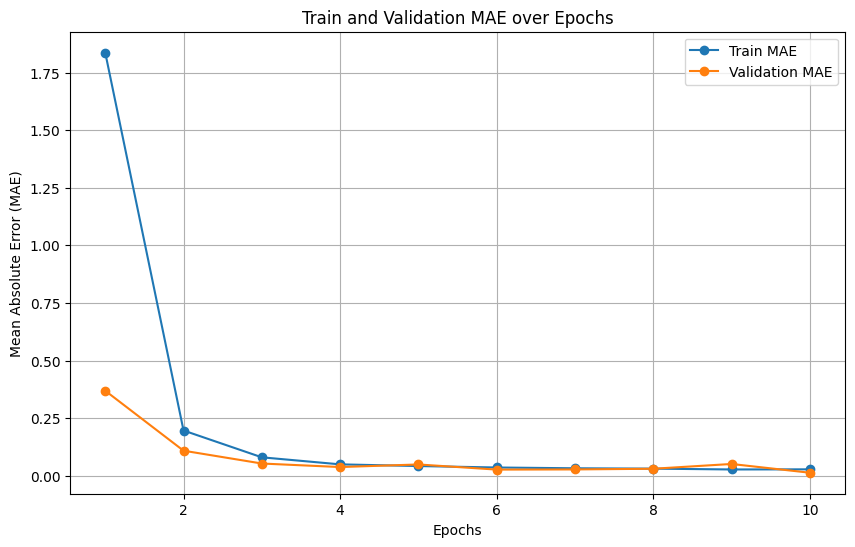

In [27]:
# Plotting function
def plot_mae(train_mae, val_mae):
    epochs = range(1, len(train_mae) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mae, label="Train MAE", marker='o')
    plt.plot(epochs, val_mae, label="Validation MAE", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.title("Train and Validation MAE over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

# Call the plot function
plot_mae(train_mae_history, val_mae_history)


In [28]:
# Function to evaluate the model's MAE on the test set
def evaluate_model_mae(model, test_loader):
    model.eval()
    test_mae = 0
    total_samples = 0

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            # Model prediction
            outputs = model(sequences)
            
            # Calculate MAE between model predictions and actual labels
            mae = torch.abs(outputs.squeeze() - labels).mean().item()
            test_mae += mae * len(sequences)
            total_samples += len(sequences)
    
    test_mae /= total_samples
    return test_mae

In [29]:
# Function to evaluate the random baseline MAE on the test set
def evaluate_random_baseline(test_loader):
    random_mae = 0
    total_samples = 0
    
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            # Generate random predictions within [0, sequence length] for each sequence
            random_predictions = torch.tensor([np.random.randint(0, len(seq) + 1) for seq in sequences]).float().to(device)
            
            # Calculate MAE between random predictions and actual labels
            mae = torch.abs(random_predictions - labels).mean().item()
            random_mae += mae * len(sequences)
            total_samples += len(sequences)
    
    random_mae /= total_samples
    return random_mae

In [30]:
# Calculate both the model's MAE and the random baseline MAE
model_test_mae = evaluate_model_mae(model, test_loader)
random_baseline_mae = evaluate_random_baseline(test_loader)

print(f"Model Test MAE: {model_test_mae:.4f}")
print(f"Random Baseline Test MAE: {random_baseline_mae:.4f}")

# Comparison
if model_test_mae < random_baseline_mae:
    print("The model performs better than the random baseline.")
else:
    print("The model performs worse than or equal to the random baseline.")

Model Test MAE: 0.0130
Random Baseline Test MAE: 5.4843
The model performs better than the random baseline.


In [31]:
# Function to generate binary sequences and their counts
def generate_sequences_by_length(length, num_samples=1000):
    sequences = []
    counts = []
    for _ in range(num_samples):
        sequence = np.random.choice([0, 1], size=length).tolist()
        count_of_ones = sum(sequence)
        sequences.append(sequence)
        counts.append(count_of_ones)
    return sequences, counts

In [32]:
# Function to calculate MAE for each sequence length
def evaluate_ood_generalization(model, max_length=32):
    length_mae = {}

    for length in range(1, max_length + 1):
        sequences, counts = generate_sequences_by_length(length)
        
        # Pad sequences to max length for batching if needed
        padded_sequences = torch.zeros((len(sequences), max_length))
        for i, seq in enumerate(sequences):
            padded_sequences[i, :len(seq)] = torch.tensor(seq)
        
        # Create DataLoader for the sequences
        labels = torch.tensor(counts, dtype=torch.float32)
        dataset = TensorDataset(padded_sequences, labels)
        data_loader = DataLoader(dataset, batch_size=32)
        
        # Evaluate model on the current length
        model.eval()
        total_mae = 0
        total_samples = 0
        
        with torch.no_grad():
            for batch_sequences, batch_labels in data_loader:
                batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
                
                # Predict
                outputs = model(batch_sequences[:, :length])  # Only use the first `length` elements of each sequence
                
                # Calculate MAE for the batch
                mae = torch.abs(outputs.squeeze() - batch_labels).mean().item()
                total_mae += mae * len(batch_sequences)
                total_samples += len(batch_sequences)
        
        # Average MAE for this length
        length_mae[length] = total_mae / total_samples
    
    return length_mae

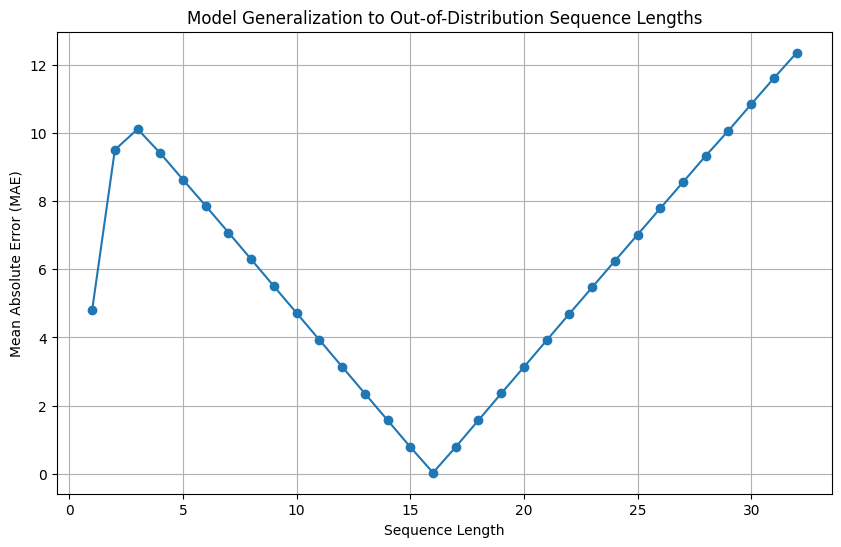

In [33]:
# Run evaluation for OOD data
length_mae_dict = evaluate_ood_generalization(model, max_length=32)

# Plot the results
lengths = list(length_mae_dict.keys())
mae_values = list(length_mae_dict.values())

plt.figure(figsize=(10, 6))
plt.plot(lengths, mae_values, marker='o')
plt.xlabel("Sequence Length")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Generalization to Out-of-Distribution Sequence Lengths")
plt.grid(True)
plt.show()

<h2>Expected Trend</h2>
<p>Since the model was trained on sequence lengths between 1 and 16, it is expected to perform better on sequences of these lengths, resulting in relatively low MAE values. For sequence lengths beyond this range (17–32), the model is likely to experience a higher MAE as it encounters lengths it has never seen during training.</p>

<h2>Interpretation of the Results:</h2>

<p>Sequence Lengths 1–16: The MAE is lower and stable as the model has learned to count within this range during training.
Sequence Lengths 17–32: A progressive increase in MAE is expected as the sequence length increases, as the model has to generalize counting accurately beyond its training distribution.</p>